# Description:

This notebook is meant to serve as a walkthrough for the Energy Demand Forecasting Pipeline Project. It details how to use each of the three Python modules included in order to obtain a dataset, process it, and use it to fit a probabilistic forecasting model. This notebook does not outline how to run or access the interactive web-based application as that portion of the project is still under development. In the following cell, all necessary libraries and project modules are imported.

### Import libraries

In [143]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import os
import itertools
import warnings
import random
import pickle as pkl
from IPython.display import Image

# import custom module
import preprocessing as pp
import model_definitions as md

# prevent logging when fitting Prophet models
# import logging
# logger = logging.getLogger('cmdstanpy')
# logger.addHandler(logging.NullHandler())
# logger.propagate = False
# logger.setLevel(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data From EIA, NOAA, and BLS

In [4]:
%run get_data.py "2018-06-19" "2024-02-25" "2eMANbsIGfgiA0uD42AeM7vo7EjbjGPgoGucnp5S"
# run python script to load data and save to Datasets/prelim.csv

Requesting energy demand data from EIA over 10 requests
Requesting energy price data from EIA
Requesting Weather Data from NOAA
Requesting data from Bereau of Labor Statistics
All data loaded successfully. Saving preliminary dataset to Saved/Datasets/preliminary.csv
Preliminary dataset saved.


# Show Summary Information about Preliminary Dataset

In [69]:
# display summary of dataset
preliminary_data = pd.read_csv(r"Saved/Datasets/preliminary.csv", index_col=0)
desciptions = preliminary_data.describe().round(2)
cols_per_table = 6
for n in range(0,int(np.ceil(desciptions.shape[1]/cols_per_table))):
    # print(n*cols_per_table, (n*cols_per_table)+cols_per_table)
    display(desciptions.iloc[:,n*cols_per_table : (n*cols_per_table)+cols_per_table])

Energy Demand (MWH)  HourlyDewPointTemperature  \
count             49843.00                   47372.00   
mean               5707.00                      43.11   
std                1222.64                      19.12   
min                   0.00                     -17.00   
25%                4816.00                      28.00   
50%                5544.00                      45.00   
75%                6280.00                      60.00   
max               11069.00                      79.00   

       HourlyDryBulbTemperature  HourlyPrecipitation  HourlyRelativeHumidity  \
count                  47381.00             44674.00                47372.00   
mean                      57.21                 0.01                   62.31   
std                       16.84                 0.05                   19.59   
min                        2.00                 0.00                    7.00   
25%                       44.00                 0.00                   47.00   
50%                       58.00                 0.00                   61.00   
75%                       72.00                 0.00                   78.00   
max                       95.00                 3.47                  100.00   

       HourlyStationPressure  
count               47171.00  
mean                   29.88  
std                     0.23  
min                    28.71  
25%                    29.73  
50%                    29.88  
75%                    30.04  
max                    30.59

HourlyWetBulbTemperature  HourlyWindSpeed  Energy Price (cents/KWH)  \
count                  47145.00         40215.00                  48523.00   
mean                      50.52             4.99                     19.88   
std                       15.63            19.62                      1.97   
min                        0.00             0.00                     16.85   
25%                       38.00             3.00                     18.38   
50%                       51.00             5.00                     19.29   
75%                       64.00             7.00                     21.64   
max                       81.00          2237.00                     23.95   

          CPI-U  Unemployment Rate  Unemployment Level  
count  49266.00           48523.00            48523.00  
mean     295.43               7.14           293521.00  
std       17.72               3.97           156851.54  
min      273.84               3.30           140697.00  
25%      279.47               4.30           183574.00  
50%      289.49               5.40           222617.00  
75%      313.88               9.90           409961.00  
max      328.01              21.50           836383.00

Employment Level  Labor Force Level  Employment Population Ratio  \
count          48523.00           48523.00                     48523.00   
mean         3853778.76         4147299.76                        55.76   
std           238814.31          103952.79                         3.58   
min          3046955.00         3707014.00                        42.90   
25%          3712627.00         4085159.00                        54.30   
50%          3897289.00         4122588.00                        57.40   
75%          4076332.00         4254770.00                        57.90   
max          4141201.00         4322118.00                        59.10   

       Labor Force Participation  Civilian Noninstitutional Population  \
count                   48523.00                              48523.00   
mean                       59.99                            6915693.82   
std                         1.72                             174856.23   
min                        52.00                            6641170.00   
25%                        59.60                            6746032.00   
50%                        60.10                            6918967.00   
75%                        60.90                            7107466.00   
max                        62.80                            7131615.00   

       Payroll Employment  
count            48523.00  
mean              4465.78  
std                260.26  
min               3748.60  
25%               4225.70  
50%               4563.10  
75%               4661.90  
max               4756.70

# Reduce Dataset by Removing Redundant Variables

In [130]:
variables_considered = ["Energy Demand (MWH)", "HourlyDryBulbTemperature", 
    "HourlyPrecipitation", "HourlyWindSpeed", "Energy Price (cents/KWH)", "Civilian Noninstitutional Population", 
    "CPI-U"]
preliminary_dataset = preliminary_data[variables_considered]

# Conduct Data Processing and Cleaning

In [84]:
# instantiate processing class
processor = pp.PreprocessingPipeline()

In [85]:
# run processing pipeline, generating eda visuals along the way
warnings.filterwarnings('ignore', category=UserWarning) # prevents warnings from Seaborn library
clean_training_data, residuals = processor.process_dataset(preliminary_dataset=preliminary_dataset)
warnings.resetwarnings()

Interpolating for variable Energy Demand (MWH)
Interpolating for variable HourlyDryBulbTemperature
Interpolating for variable HourlyWindSpeed
Interpolating for variable Energy Price (cents/KWH)
Interpolating for variable Civilian Noninstitutional Population
Interpolating for variable CPI-U
Interpolating for variable HourlyPrecipitation


# Instantiate and Tune Forecasting Model

In [86]:
model = md.Forecaster()

In [54]:


hyperparameter_sets = dict(changepoint_prior_scale=[0.001], seasonality_prior_scale=[0.01], point_var_lags=[10], minimum_error_prediction=[100, 500, None], error_trend=[1e-2, 1e-1, 1, 10])

keys = hyperparameter_sets.keys()
values = hyperparameter_sets.values()
# Generate all possible combinations of values
combinations = itertools.product(*values)
# Create a list of dictionaries with all combinations
hyperparameter_sets = [dict(zip(keys, vals)) for vals in combinations]

# display(hyperparameter_sets)

hyperparameter_results = model.tune_hyperparameters(clean_training_data=clean_training_data, dependent_variable="Energy Demand (MWH)", hyperparameter_sets=hyperparameter_sets, num_cv_folds=5)

# get best set of hyperparameters

In [64]:
wmses = [x[2] for x in hyperparameter_results]
best_set = hyperparameter_results[np.argmin(wmses)][0]
print(best_set)



{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'point_var_lags': 10, 'minimum_error_prediction': 100, 'error_trend': 10}


# Cross Validate best set of hyperparameters

In [65]:
# mse, wmse = model.cross_validate(num_folds=5, clean_training_data=clean_training_data, dependent_variable="Energy Demand (MWH)", 
#     hyperparameters=dict(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01, point_var_lags=10, minimum_error_prediction=None, error_trend=1))
mse, wmse = model.cross_validate(num_folds=5, clean_training_data=clean_training_data, dependent_variable="Energy Demand (MWH)", 
    hyperparameters=best_set)

display(mse, wmse)

1602027.7233872826

1363747.8899850005

# Fit Final Model

In [87]:
warnings.filterwarnings('ignore')
model.fit(clean_training_data=clean_training_data, dependent_variable="Energy Demand (MWH)", hyperparameters=best_set)

# Evaluate on Holdout Data

In [108]:
# load holdout data
evaluation_data = pd.read_csv(r"Saved/Datasets/holdout.csv", index_col=0)
evaluation_data.index = pd.to_datetime(evaluation_data.index)

# get complete range to be predicted (in case the holdout set is missing any values)
complete_range = pd.date_range(start=evaluation_data.index.min(), end=evaluation_data.index.max(), freq='H')

# make forecasts
point_forecasts, variance_forecasts = model.predict(complete_range.shape[0])
forecasts = pd.DataFrame(index=complete_range, data={"Point Forecasts":point_forecasts, "Variance Forecasts":variance_forecasts})

# reconcile forecasts and ground truth values
results = pd.merge(forecasts, evaluation_data, left_index=True, right_index=True, how="inner")
point_forecasts = results["Point Forecasts"].values
variance_forecasts = results["Variance Forecasts"].values
actual_values = results["Energy Demand (MWH)"].values

In [104]:
df = model.error_prophet_model.make_future_dataframe(periods=evaluation_data.shape[0], freq="H")
# display(df)
t = df.iloc[-evaluation_data.shape[0]:]


In [120]:
# Combine error forecasts
std_forecasts = np.sqrt(variance_forecasts)
lower_cuts = point_forecasts - 1.96 * std_forecasts  # 1.96 is the z-value for the 2.5th percentile of the standard normal distribution
upper_cuts = point_forecasts + 1.96 * std_forecasts

fig = go.Figure()
fig.add_trace(go.Scatter(x=evaluation_data.index, y=point_forecasts, mode='lines', name='Point Forecasts', line=dict(color='rgba(255, 0, 0)')))
fig.add_trace(go.Scatter(x=evaluation_data.index, y=actual_values, mode='lines', name='Ground Truth', line=dict(color='rgba(0, 0, 255)')))
fig.add_trace(go.Scatter(x=evaluation_data.index, y=upper_cuts, mode='lines', name='Upper 95 CI', line=dict(color='rgba(0, 255, 0, 0.2)')))
fig.add_trace(go.Scatter(x=evaluation_data.index, y=lower_cuts, mode='lines', name='Lower 95 CI', line=dict(color='rgba(200, 125, 200, 0.2)')))

# Customize the layout
fig.update_layout(
    title="",
    xaxis_title='Time',
    yaxis_title='Energy Demand (MWH)',
    template='plotly_dark'  # Use a dark theme
)


### Measure Final Model Performance

In [129]:
# define baseline model as simple year-long moving average
sma = clean_training_data["Energy Demand (MWH)"].rolling(window=24*365).mean()
baseline_prediction = sma.iloc[-1]
sma_error = pd.merge(clean_training_data["Energy Demand (MWH)"], sma, left_index=True, right_index=True, how="inner", suffixes=["_actual", "_baseline_prediction"])
sma_error = sma_error[sma_error["Energy Demand (MWH)_baseline_prediction"].notna()]
baseline_variance = ((sma_error["Energy Demand (MWH)_baseline_prediction"] - sma_error["Energy Demand (MWH)_actual"]).values**2).sum()/sma_error.shape[0]
display(baseline_prediction)
display(baseline_variance)

# statistical comparison between baseline forecasting model and created forecasting model


5574.457560475597

1442745.124967732

# Testing EDA Visuals

### Check that all outlier plots were created

In [141]:
# check that all numerical variables have outlier identification plots
for variable in clean_training_data.select_dtypes("number").columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Plotly Figures/Outlier Detection"
    filepath = r"{}/{}.pkl".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The outlier plot for {} is missing".format(variable))


# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in clean_training_data.select_dtypes("number")])
filepath = r"{}/{}.pkl".format(directory, variable)
with open(filepath, 'rb') as file:
    figure = pkl.load(file)
figure.show()

### Load Random Distribution

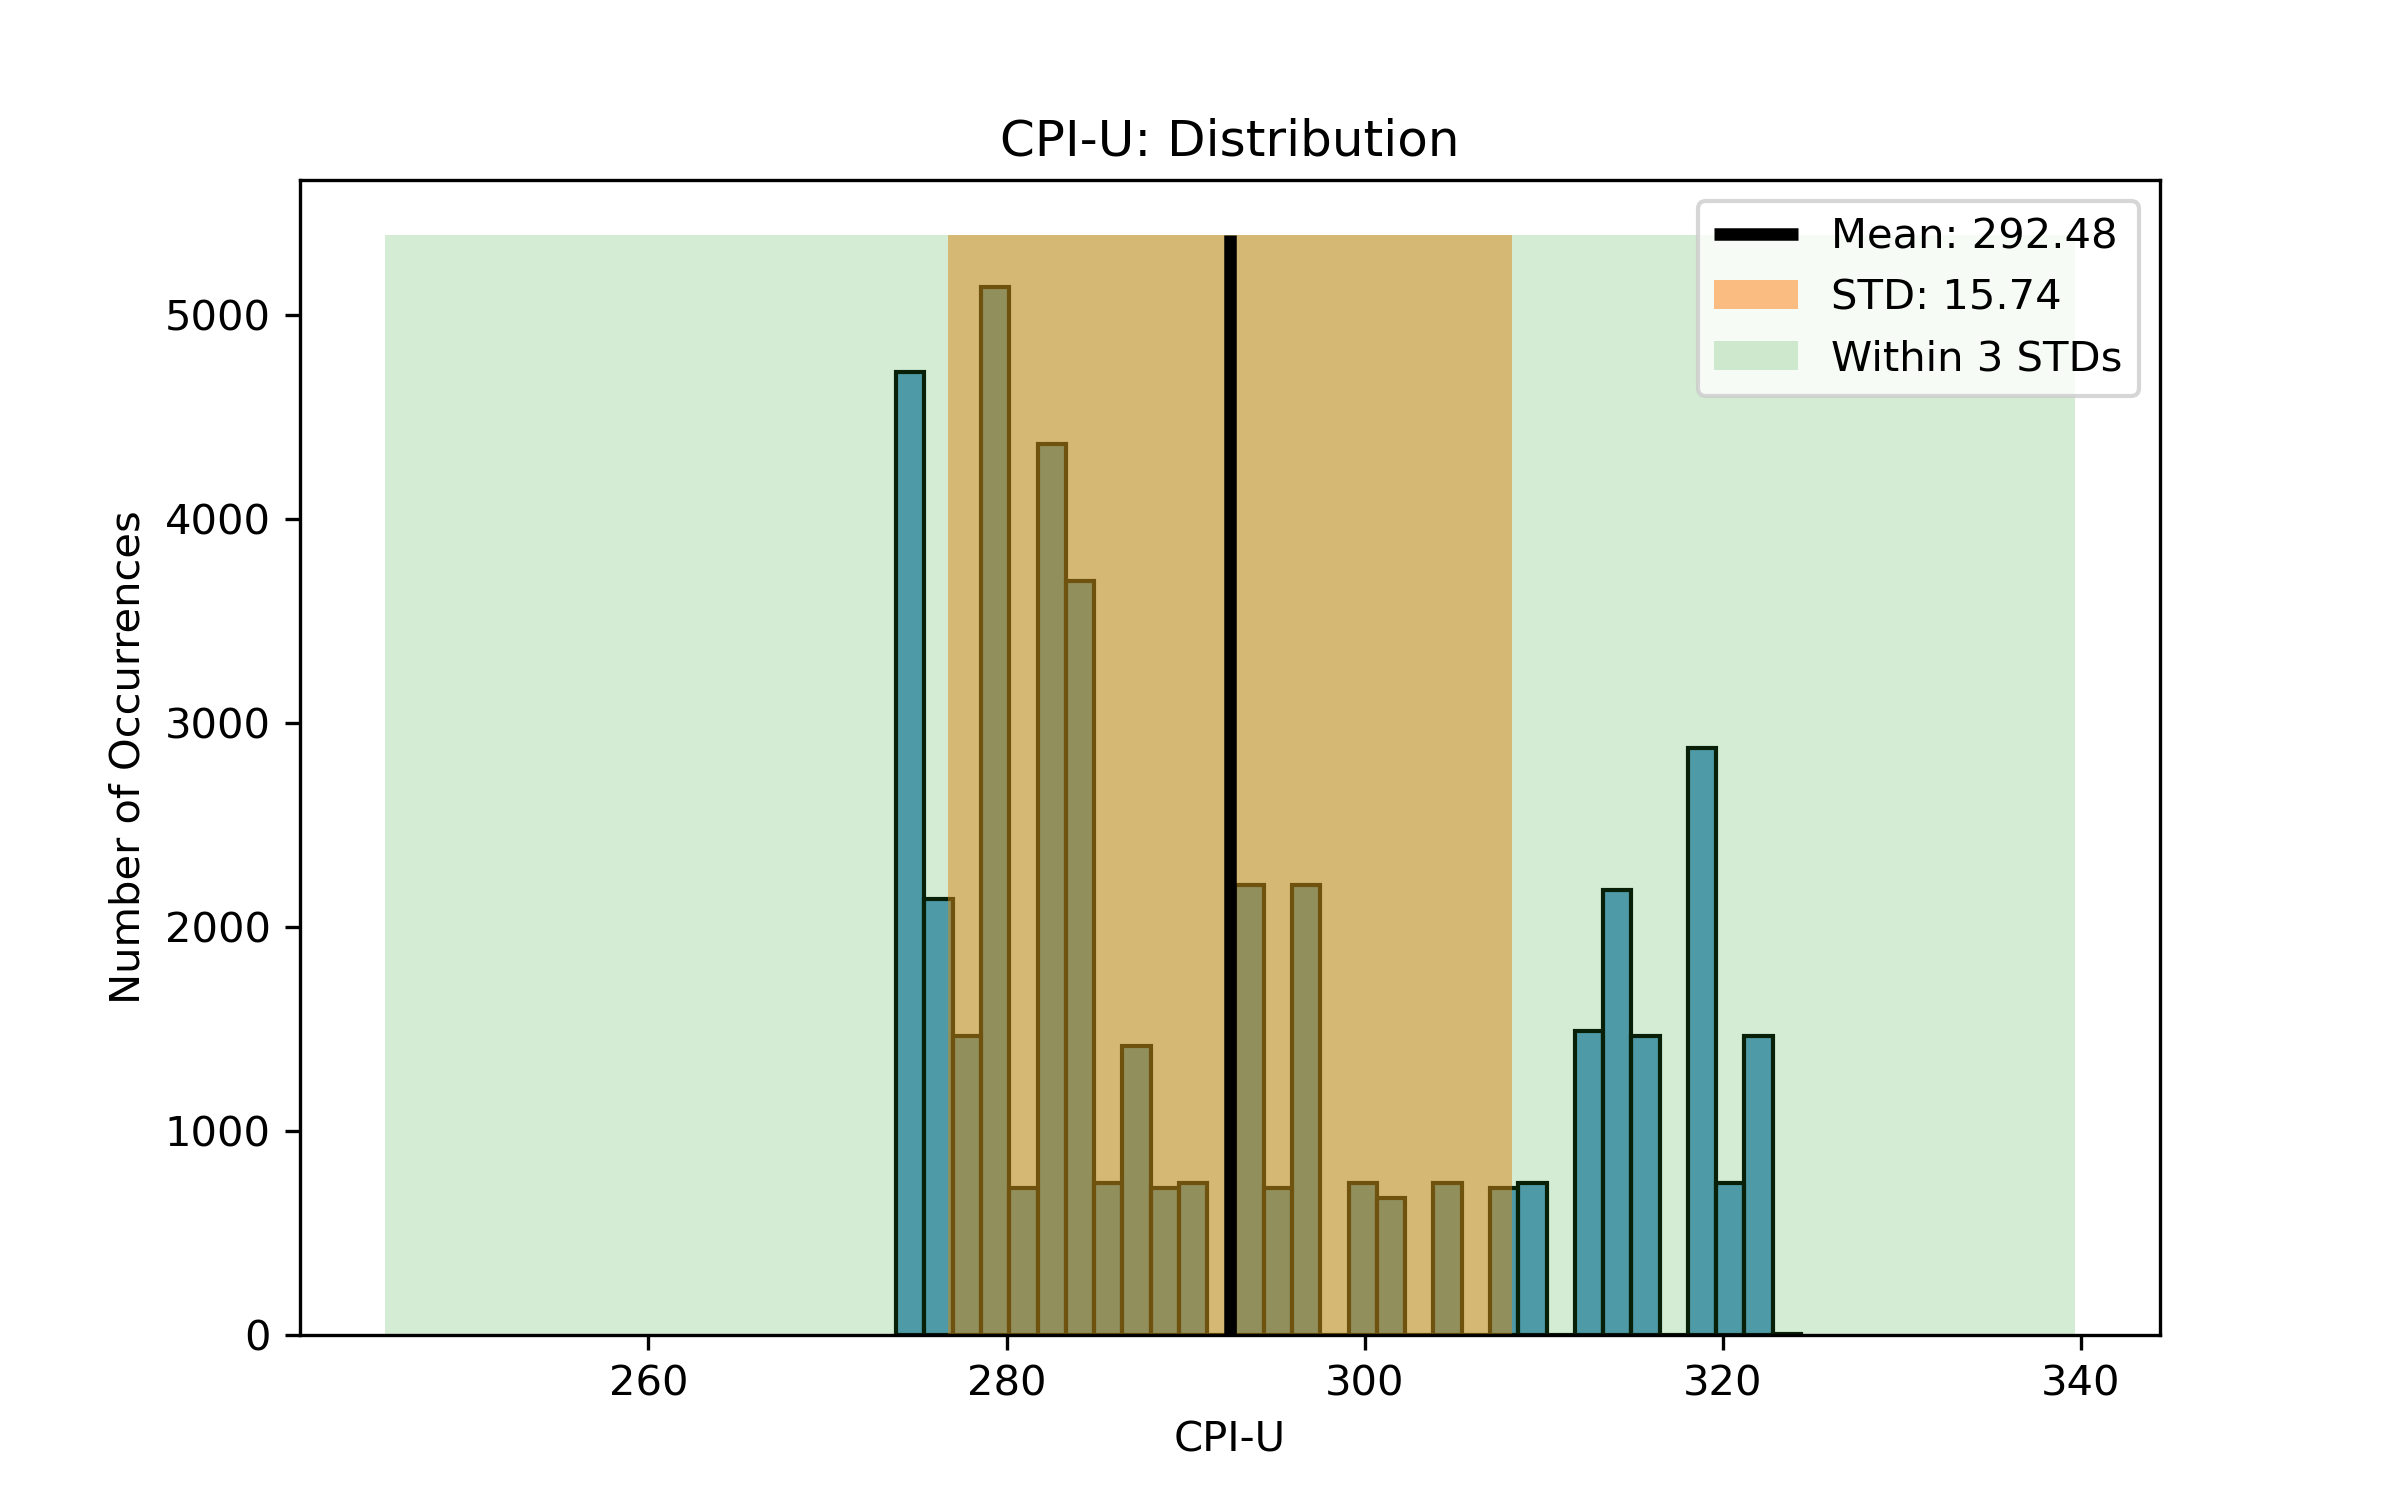

In [151]:
# check that all numerical variables have scatterplots
for variable in preliminary_dataset.columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Static Visuals/Distributions"
    filepath = r"{}/{}.png".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The distribution plot for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in preliminary_dataset.columns])
filepath = r"{}/{}.png".format(directory, variable)

# Display the PNG file
Image(filename=filepath, width=750)

### Load Random Scatterplot

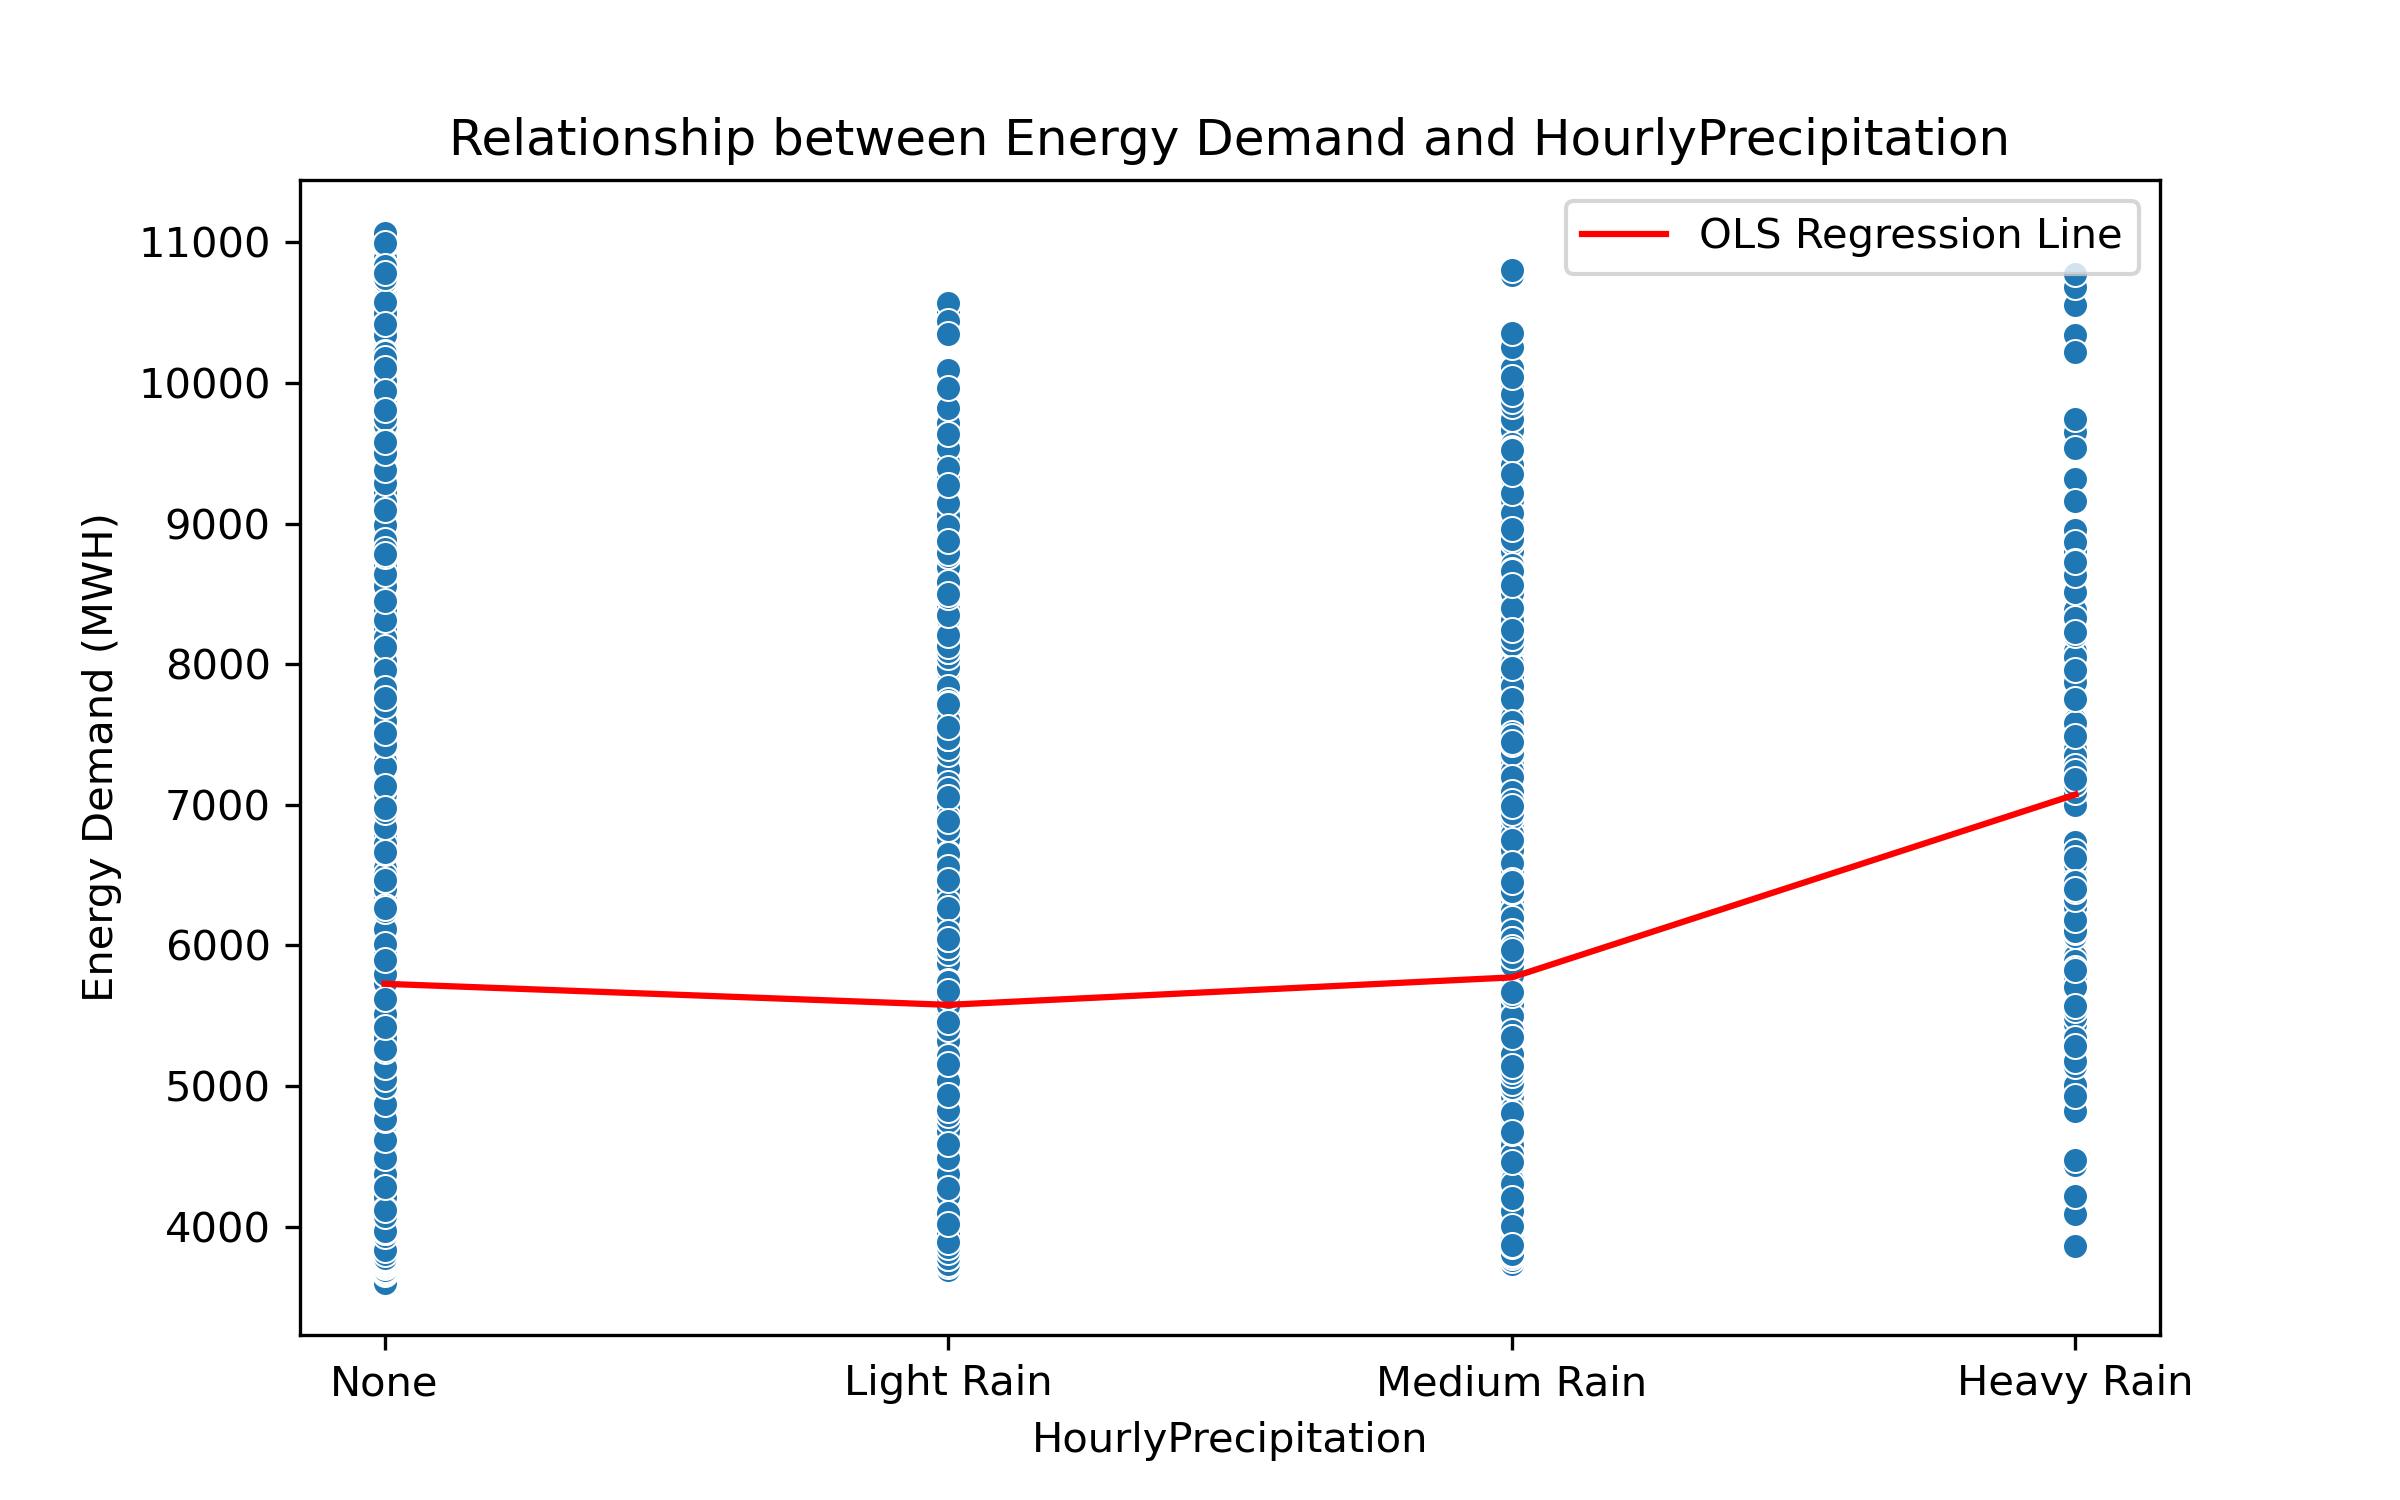

In [150]:
# check that all numerical variables have scatterplots
for variable in preliminary_dataset.columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Static Visuals/Scatterplots"
    filepath = r"{}/{}.png".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The scatterplot for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in preliminary_dataset.columns])
filepath = r"{}/{}.png".format(directory, variable)

# Display the PNG file
Image(filename=filepath, width=750)

### Load Random Time Series Decomposition Plot

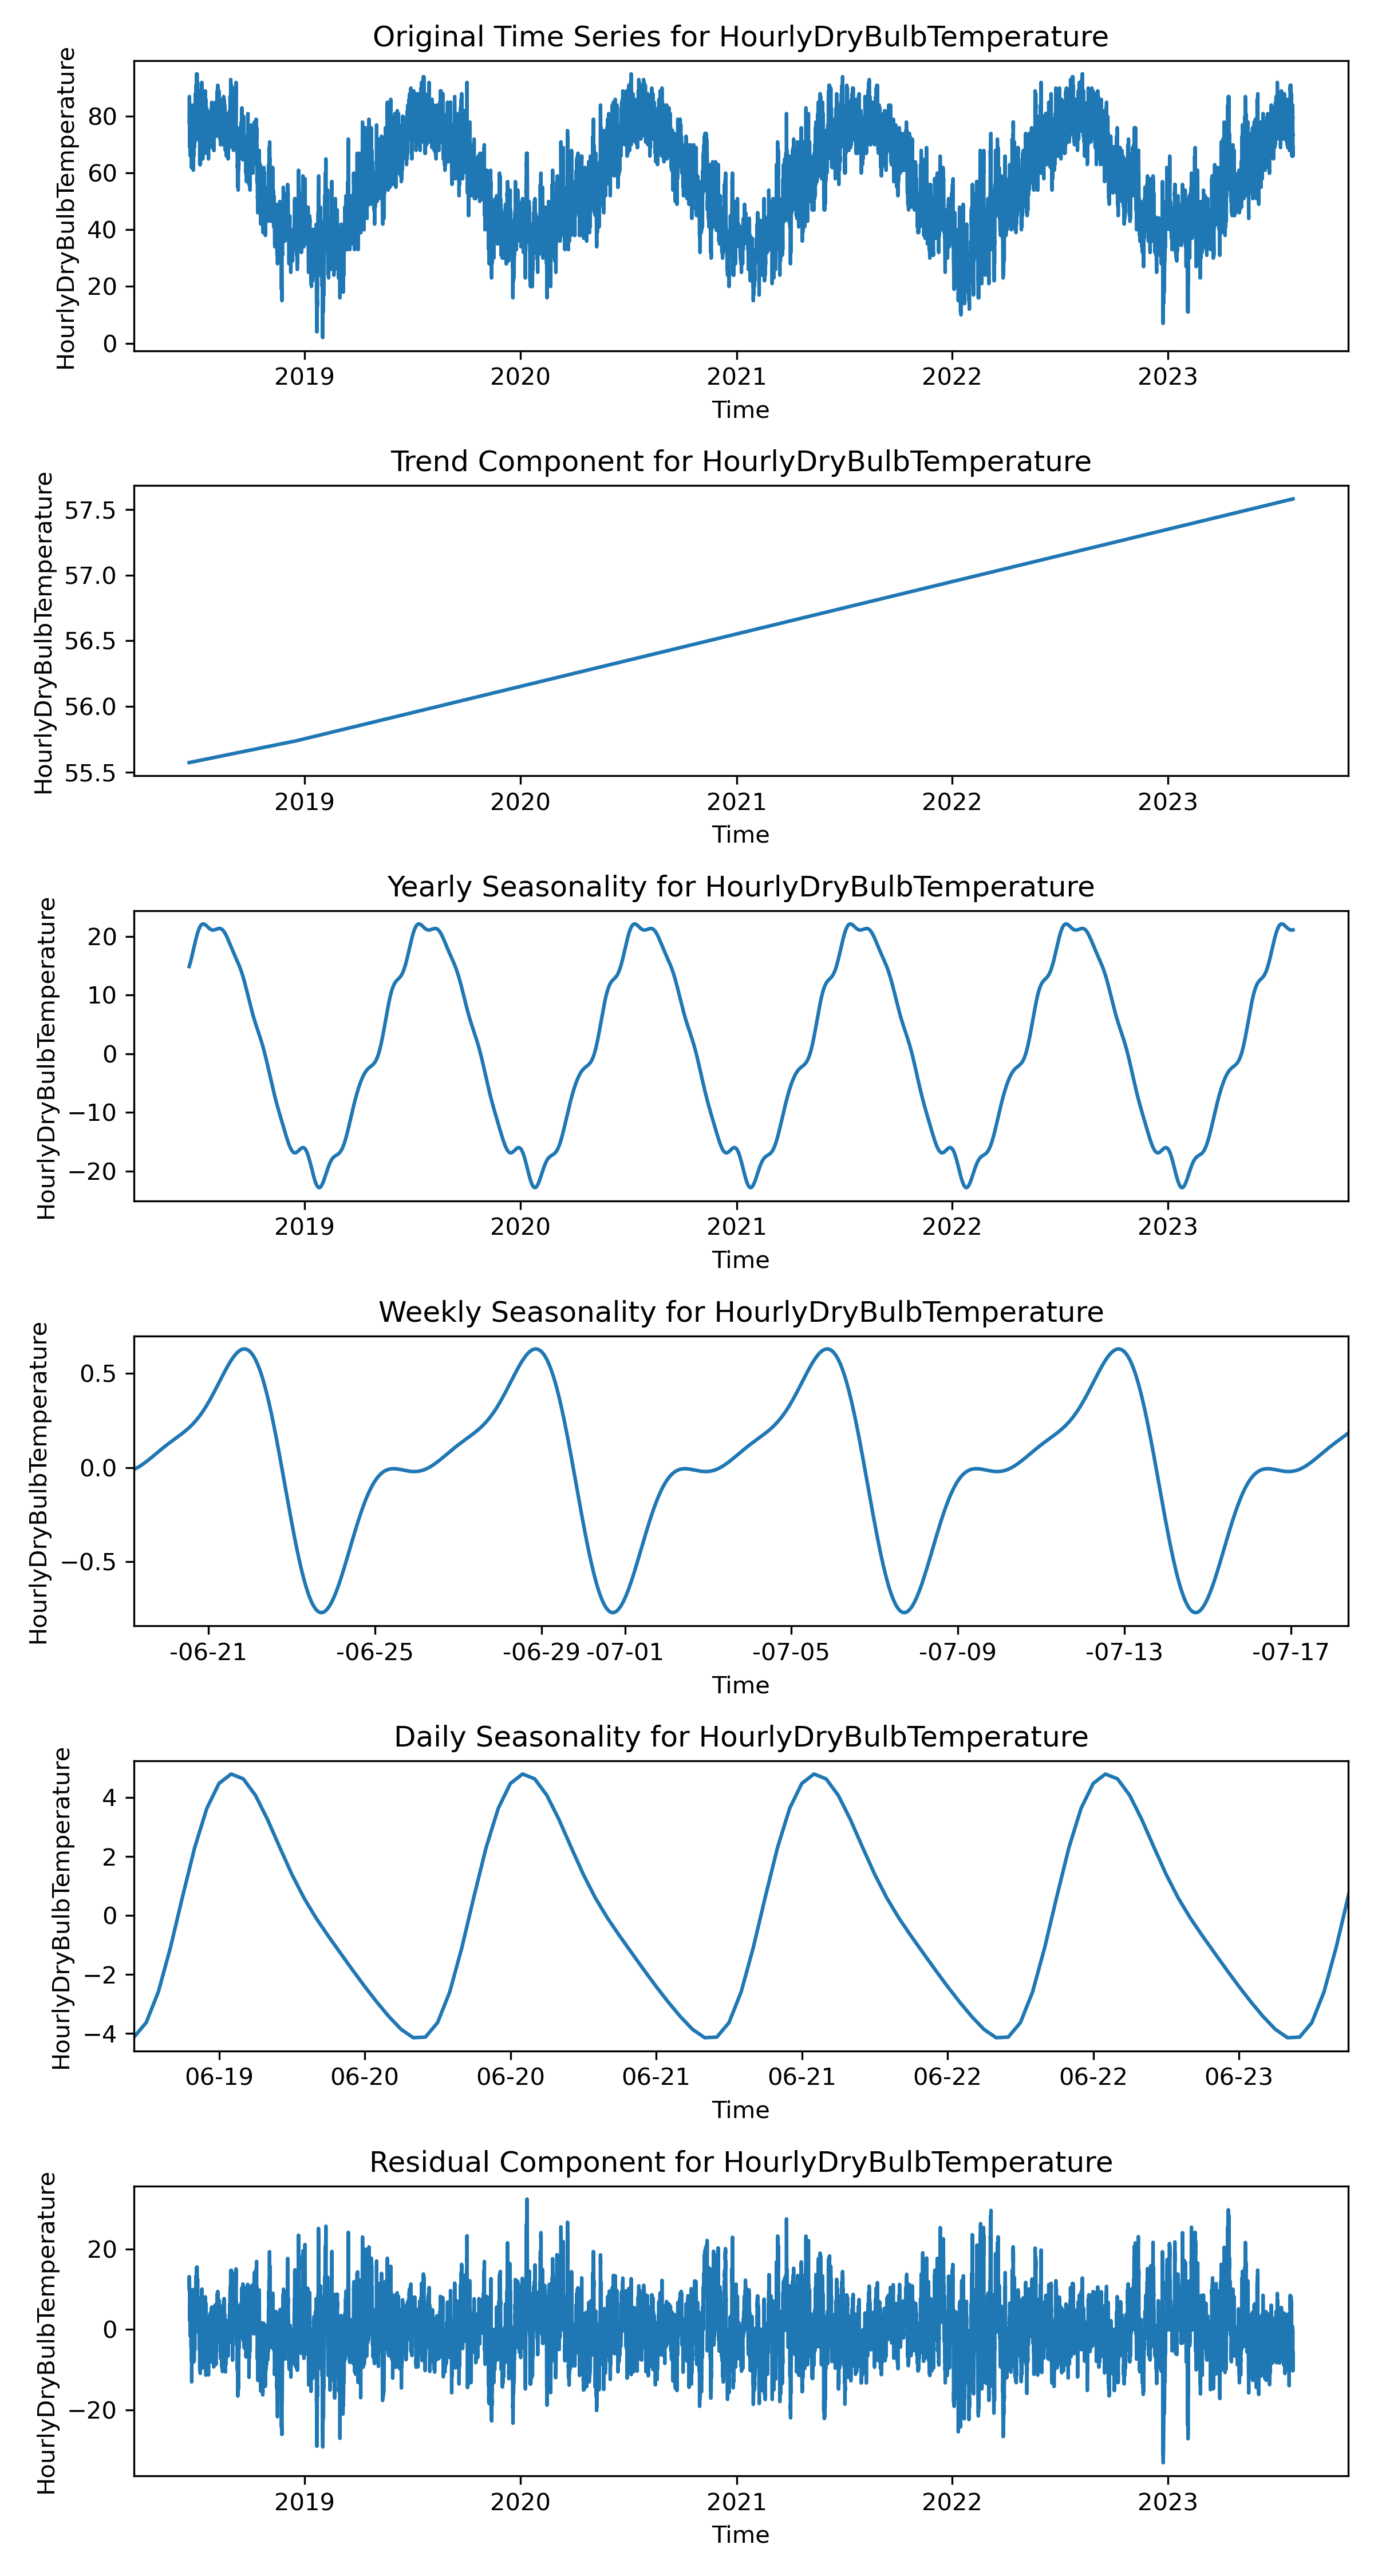

In [152]:
# check that all numerical variables have scatterplots
for variable in clean_training_data.select_dtypes("number").columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Static Visuals/Decompositions"
    filepath = r"{}/{}.png".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The time series decomposition for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in clean_training_data.select_dtypes("number")])
filepath = r"{}/{}.png".format(directory, variable)

# Display the PNG file
Image(filename=filepath, width=750)